In [2]:
import numpy as np
import matplotlib.pylab as plt
import os

folder = "./RESULTS/figures/suppl-review"
if not os.path.exists(folder):
    os.mkdir(folder)
fmt = "svg"

In [3]:
def FFT_sampling_points (delta_t, length=180, bin1=2.4, bin2=2.1, eps=0.0001):
    """
    Calculates the number of sampling points for the FFT based on the
        current fmri series. For some reason the MR technitian
        decided to use a temproal bin of either 2.4 or 2.1 seconds.
    To be used only in the rfft function!

    Inputs:
    -------

    Outputs:
    --------

    """
    bin = np.max([bin1, bin2])
    if (delta_t >= bin-eps)*(delta_t <= bin+eps):
        extra_bins = 0
    else:
        extra_bins = int(np.abs(bin1-bin2)*length/delta_t)+1 # Padding added to the short time series (in seconds!)
        
    points = length + extra_bins
    if points%2 == 0:
        fft_length = int(length/2 + 1)
    else:
        fft_length = int((length+1)/2)
    
    return points, fft_length

bin_size = 5
def FFT_dynamics(fft, bin_size=bin_size):
    cutoffs = np.zeros((100//bin_size,), dtype=np.int64)
    bin_power, cum_power = np.zeros((100//bin_size,)), np.zeros((100//bin_size,))
    lower_cut = 0
    for j, percent in enumerate(range(bin_size, 100+bin_size, bin_size)):
        cutoff = int(len(fft)*percent/100)
        cutoffs[j] = percent
        fft_cut = fft[:cutoff]
        bin_power[j] = np.sum(np.square(np.abs(fft[lower_cut:cutoff])))
        cum_power[j] = np.sum(np.square(np.abs(fft_cut)))
        lower_cut = cutoff
    total_power = cum_power[-1]
    bin_power = 100*bin_power/cum_power[-1]
    cum_power = 100*cum_power/cum_power[-1]

    return total_power, bin_power, cum_power

In [4]:
TR_1 = 2.4 # Longer time series in seconds
TR_2 = 2.1 # Shorter time series in seconds

length = 180
points_1, points_2 = [], []
for i in range(length):
  points_1.append(i*TR_1)
  points_2.append(i*TR_2)
points_1, points_2 = np.array(points_1), np.array(points_2)

freq_1, freq_2 = 0.1, 1
signal_1 = 0.8 * np.sin(freq_1 * points_1) + 0.4 * np.sin(freq_2 * points_1+0.1)
signal_2 = 0.8 * np.sin(freq_1 * points_2) + 0.4 * np.sin(freq_2 * points_2+0.1)

print("Number fo sampled time points for both TRs: ", len(points_1), len(points_2))
print(f"Sampled points for TR={TR_1}: ", points_1[:10])
print(f"Sampled points for TR={TR_2}: ", points_2[:10])

Number fo sampled time points for both TRs:  180 180
Sampled points for TR=2.4:  [ 0.   2.4  4.8  7.2  9.6 12.  14.4 16.8 19.2 21.6]
Sampled points for TR=2.1:  [ 0.   2.1  4.2  6.3  8.4 10.5 12.6 14.7 16.8 18.9]


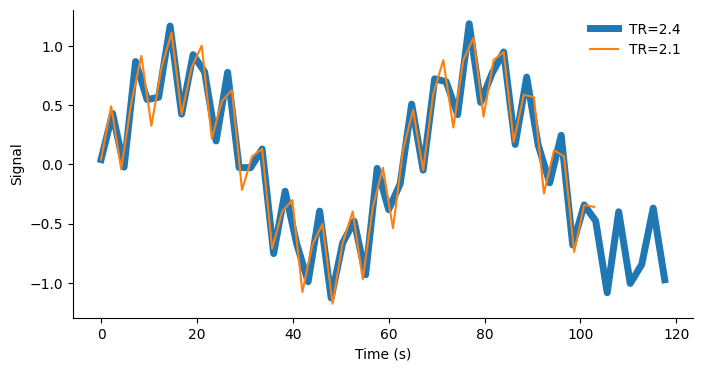

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(points_1[:50], signal_1[:50], '-', lw=5, label=f"TR={TR_1}")
ax.plot(points_2[:50], signal_2[:50], '-', label=f"TR={TR_2}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal")
plt.legend(frameon=False)
plt.savefig(folder+f"/series.{fmt}", format=fmt, dpi=500)

## Sampling frequencies before and after the padding

Displaying info for original series:
Original signal with TR = 2.4. Sampling frequencies: [0.     0.0023 0.0046 0.0069 0.0093] to [0.1991 0.2014 0.2037 0.206  0.2083]
Original signal with TR = 2.1. Sampling frequencies: [0.     0.0026 0.0053 0.0079 0.0106] to [0.2275 0.2302 0.2328 0.2354 0.2381]
Displaying info for padded series:
Padded signal with TR = 2.4. Sampling frequencies: [0.     0.0023 0.0046 0.0069 0.0093] to [0.1991 0.2014 0.2037 0.206  0.2083]
Padded signal with TR = 2.1. Sampling frequencies: [0.     0.0023 0.0046 0.0069 0.0092] to [0.1988 0.2011 0.2034 0.2057 0.208 ]


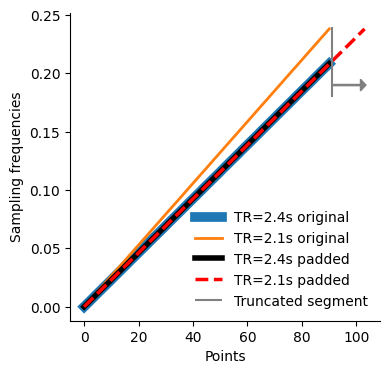

In [18]:
# Original sampling
freqs_1 = np.round(np.fft.rfftfreq(length, d=TR_1), 4)
freqs_2 = np.round(np.fft.rfftfreq(length, d=TR_2), 4)

# Padding sampling
n1_pad, fft_n1_pad = FFT_sampling_points(TR_1, length=length)
n2_pad, fft_n2_pad = FFT_sampling_points(TR_2, length=length)
freqs_1_pad = np.round(np.fft.rfftfreq(n1_pad, d=TR_1), 4)
freqs_2_pad = np.round(np.fft.rfftfreq(n2_pad, d=TR_2), 4)

print("Displaying info for original series:")
print(f"Original signal with TR = {TR_1}. Sampling frequencies: {freqs_1[:5]} to {freqs_1[-5:]}")
print(f"Original signal with TR = {TR_2}. Sampling frequencies: {freqs_2[:5]} to {freqs_2[-5:]}")
print("Displaying info for padded series:")
print(f"Padded signal with TR = {TR_1}. Sampling frequencies: {freqs_1_pad[:5]} to {freqs_1_pad[-5:]}")
print(f"Padded signal with TR = {TR_2}. Sampling frequencies: {freqs_2_pad[:5]} to {freqs_2_pad[len(freqs_2)-5:len(freqs_2)]}")

fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot(freqs_1, lw=7, label=f"TR={TR_1}s original")
ax.plot(freqs_2, lw=2, label=f"TR={TR_2}s original")
ax.plot(freqs_1_pad, 'k', lw=4, label=f"TR={TR_1}s padded")
ax.plot(freqs_2_pad, '--r', lw=2.5, label=f"TR={TR_2}s padded")
ax.vlines(len(freqs_2), ymin=.18, ymax=.24, color='gray', linewidth=1.5, label="Truncated segment")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Points")
ax.set_ylabel("Sampling frequencies")
plt.arrow(len(freqs_2)+.5, .19, 10, 0, head_width=.01, head_length=2, color='gray')
plt.legend(frameon=False)
plt.savefig(folder+f"/frequencies.{fmt}", format=fmt, dpi=500)

# Raw signals

In [7]:
# Compute Fourier Transforms
fft_1 = np.fft.rfft(signal_1)
fft_2 = np.fft.rfft(signal_2)
print(len(fft_1), len(fft_2))

# Compute power statistics
total_power_1, bin_power_1, cum_power_1 = FFT_dynamics(fft_1)
total_power_2, bin_power_2, cum_power_2 = FFT_dynamics(fft_2)

91 91


In [8]:
# Print numbers
print(f"Total power TR={TR_1}: {total_power_1}")
print(f"Total power TR={TR_2}: {total_power_2}")

# Compute DAS
DAS = np.trapz(cum_power_1-cum_power_2)
print(f"Dynamics Alteration Score: {DAS} defined from TR_1 - TR_2")

Total power TR=2.4: 6494.6051963776345
Total power TR=2.1: 6461.667432727329
Dynamics Alteration Score: -37.12136334889257 defined from TR_1 - TR_2


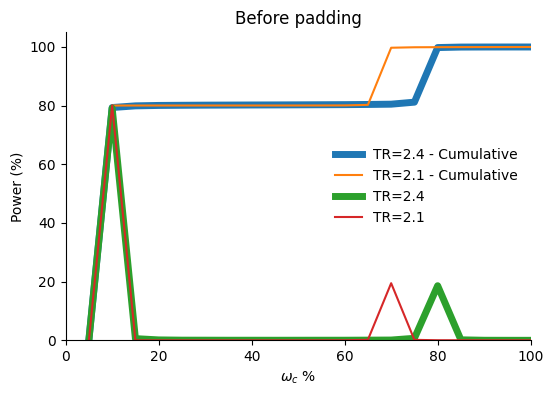

In [23]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.arange(bin_size,100+bin_size,bin_size), cum_power_1, lw=5, label=f"TR={TR_1} - Cumulative")
ax.plot(np.arange(bin_size,100+bin_size,bin_size), cum_power_2, label=f"TR={TR_2} - Cumulative")
ax.plot(np.arange(bin_size,100+bin_size,bin_size), bin_power_1, lw=5, label=f"TR={TR_1}")
ax.plot(np.arange(bin_size,100+bin_size,bin_size), bin_power_2, label=f"TR={TR_2}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Power (%)")
ax.set_xlabel(r'$\omega_{c}$ %')
ax.set_ylim([0,105])
ax.set_xlim([0,100])
ax.set_title("Before padding")
plt.legend(frameon=False)
plt.savefig(folder+f"/power-original.{fmt}", format=fmt, dpi=500)

# Padded and truncated signals

In [10]:
# Compute Fourier Transforms
n1, fft_n1 = FFT_sampling_points(TR_1, length=length)
n2, fft_n2 = FFT_sampling_points(TR_2, length=length)
print("Number of points to compute the FFTs for TR_1 and TR_2: ",n1 ,n2)
fft_1_pad = np.fft.rfft(signal_1, n=n1)
fft_2_pad = np.fft.rfft(signal_2, n=n2)
print("Length of the FFTs before truncation: ",len(fft_1_pad), len(fft_2_pad))
fft_1_pad = fft_1_pad[:fft_n1]
fft_2_pad = fft_2_pad[:fft_n2]
print("Length of the FFTs after truncation: ",fft_n1, fft_n2)

# Compute power statistics
total_power_1_pad, bin_power_1_pad, cum_power_1_pad = FFT_dynamics(fft_1_pad)
total_power_2_pad, bin_power_2_pad, cum_power_2_pad = FFT_dynamics(fft_2_pad)

Number of points to compute the FFTs for TR_1 and TR_2:  180 206
Length of the FFTs before truncation:  91 104
Length of the FFTs after truncation:  91 91


In [11]:
# Print numbers
print(f"Total power TR={TR_1}: {total_power_1_pad}")
print(f"Total power TR={TR_2}: {total_power_2_pad}")

# Compute DAS
DAS_pad = np.trapz(cum_power_1_pad-cum_power_2_pad)
print(f"Dynamics Alteration Score: {DAS_pad} defined from TR_1 - TR_2")

Total power TR=2.4: 6494.6051963776345
Total power TR=2.1: 7393.0706536464795
Dynamics Alteration Score: 1.4953204579216557 defined from TR_1 - TR_2


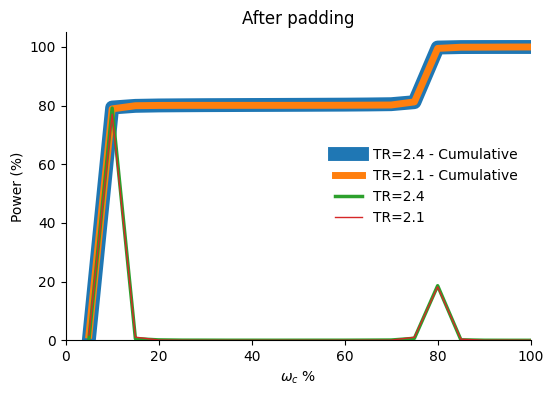

In [21]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(np.arange(bin_size,100+bin_size,bin_size), cum_power_1_pad, lw=10, label=f"TR={TR_1} - Cumulative")
ax.plot(np.arange(bin_size,100+bin_size,bin_size), cum_power_2_pad, lw=5, label=f"TR={TR_2} - Cumulative")
ax.plot(np.arange(bin_size,100+bin_size,bin_size), bin_power_1_pad, lw=2.5, label=f"TR={TR_1}")
ax.plot(np.arange(bin_size,100+bin_size,bin_size), bin_power_2_pad, lw=1, label=f"TR={TR_2}")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Power (%)")
ax.set_xlabel(r'$\omega_{c}$ %')
ax.set_ylim([0,105])
ax.set_xlim([0,100])
ax.set_title("After padding")
plt.legend(frameon=False)
plt.savefig(folder+f"/power-padded.{fmt}", format=fmt, dpi=500)

## Understanding the effects of customizing the sampling points on the total power of the signal

IMPORTANT REMINDER:

TR1 = 2.4 s

TR2 = 2.1 s

In [ ]:
# Original
fft_1 = np.fft.rfft(signal_1)
fft_2 = np.fft.rfft(signal_2)

# Power
p1 = np.square(np.abs(fft_1))
p2 = np.square(np.abs(fft_2))
tp1 = np.sum(p1)
tp2 = np.sum(p2)

# Padding
n1, fft_n1 = FFT_sampling_points(TR_1, length=length)
n2, fft_n2 = FFT_sampling_points(TR_2, length=length)
fft_1_pad = np.fft.rfft(signal_1, n=n1)[:fft_n1]
fft_2_pad = np.fft.rfft(signal_2, n=n2)[:fft_n2]

# Power
p1_pad = np.square(np.abs(fft_1_pad))
p2_pad = np.square(np.abs(fft_2_pad))
tp1_pad = np.sum(p1_pad)
tp2_pad = np.sum(p2_pad)

# Reescaling
p1_rescaled = p1_pad * (tp1 / tp1_pad)
tp1_rescaled = np.sum(p1_rescaled)
p2_rescaled = p2_pad * (tp2 / tp2_pad)
tp2_rescaled = np.sum(p2_rescaled)

print("Displaying info:")
print()
print(f"Signal with TR = {TR_1}")
print(f"Total power of the original signal with TR1: {tp1}")
print(f"Total power of the padded signal with TR1: {tp1_pad}")
print(f"Total power of the rescaled padded signal with TR1: {tp1_rescaled}")
print()
print(f"Signal with TR = {TR_2}")
print(f"Total power of the original signal with TR2: {tp2}")
print(f"Total power of the padded signal with TR2: {tp2_pad}")
print(f"Total power of the rescaled padded signal with TR2: {tp2_rescaled}")

# Effects of the bin size?

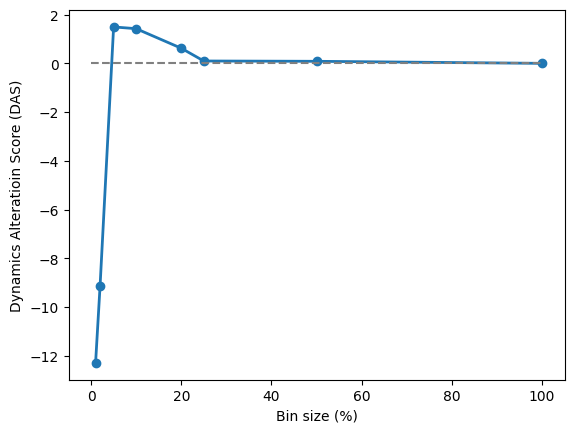

In [13]:
# Bins to test
power_bins = [1, 2, 5, 10, 20, 25, 50, 100]
DAS_bins = []

# Start the complete workflow
for i, bin in enumerate(power_bins):
    n1_bin, fft_n1_bin = FFT_sampling_points(TR_1, length=length)
    n2_bin, fft_n2_bin = FFT_sampling_points(TR_2, length=length)
    fft_1_bin = np.fft.rfft(signal_1, n=n1_bin)
    fft_2_bin = np.fft.rfft(signal_2, n=n2_bin)
    fft_1_bin = fft_1_bin[:fft_n1_bin]
    fft_2_bin = fft_2_bin[:fft_n2_bin]

    # Compute power statistics
    total_power_1_bin, bin_power_1_bin, cum_power_1_bin = FFT_dynamics(fft_1_bin, bin_size=bin)
    total_power_2_bin, bin_power_2_bin, cum_power_2_bin = FFT_dynamics(fft_2_bin, bin_size=bin)

    DAS_bins.append(np.trapz(cum_power_1_bin-cum_power_2_bin))

plt.figure()
plt.plot(power_bins, DAS_bins, '-o', lw=2)
plt.hlines(0, xmin=0, xmax=100, linestyle='dashed', colors='gray')
plt.xlabel("Bin size (%)")
plt.ylabel("Dynamics Alteratioin Score (DAS)")
plt.show()